In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt

#! Use this to get an idea on how it functions, this does not represent it properly.
#! It works well, still has crucial missing steps 

"""
# Evaluating the network on the validation set 
val_outputs = model(x_test)
val_loss = criterion(val_outputs, y_test)
print(val_loss)
"""

torch.cuda.empty_cache()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Clears memory from previous run
torch.cuda.empty_cache()

# torch.cuda.memory_summary(device=None, abbreviated=False)

C:\Users\emjan\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Synthetic Data Frame

In [2]:
# Synthetic Data - Which gets more complex step by step 


# (a) Continuous functions with linear relationship
def QL_a(y):
    #if 0 <= y <= 1:
    return 0.5 * (6 * y - 2) ** 2 * np.sin(12 * y - 4) + 10 * (y - 0.5) - 5
    #else:
    raise ValueError("(a) y must be in the range [0, 1]")

def QH_a(y):
    #if 0<= y <= 1:
    return (6 * y - 2)**2 * np.sin(12 * y - 4)
    #else:
    raise ValueError("(a) y must be in the range [0, 1]")    


# (b) Discontinuous functions with linear relationship
def QL_b(y):
    if 0 <= y and y <= 0.5:
        return 2*QL_b(y) - 20*y + 20
    elif 0.5 < y and y <= 1:
        return 4 + 2*QL_b(y) - 20*y + 20
    else:
        return ValueError("(b) Range Error")

def QH_b(y):
    if 0 <= y and y <= 0.5:
        return 0.5 * (6 * y - 2)**2 * np.sin(12 * y - 4) + 10 * (y - 0.5)
    elif 0.5 < y and y <= 1:
        return 3 + 0.5 * (6 * y - 2)**2 * np.sin(12 * y - 4) + 10 * (y - 0.5)
    else:
        return ValueError("(b) Range Error")


# (c) Continuous functions with nonlinear relationship
def QL_c(y):
    return 0.5 * (6 * y - 2)**2 * np.sin(12 * y - 4) + 10 * (y - 0.5) - 5

def QH_c(y):
    return (6 * y - 2)**2 * np.sin(12 * y - 4) - 10 * (y - 1)**2


# (d) Continuous oscillation functions with nonlinear relationship
def QL_c(y):
    if 0 <= y <= 1:
        return np.sin(8 * np.pi * y)
    else:
        return ValueError("(d) Range Error")

def QH_c(y):
    if 0 <= y <= 1:
        return (y - np.sqrt(2)) * QL_c(y) ** 2
    else:
        return ValueError("(d) Range Error")


# (e) Phase-Shifted Osicallations
def QL_e(y):
    return np.sin(8 * np.pi * y)

def QH_e(y):
    return y**2 + QL_e(y + np.pi/10)


# (f) Different Periodicities
def QL_f(y):
    return np.sin(6 * np.sqrt(2) * np.pi * y)

def QH_f(y):
    return np.sin(8 * np.pi * y + np.pi / 10)


# (g) 50-Dimensional Functions 


# ----------------------------Data Array------------------------------
n = 1000 # number of points
X = torch.linspace(0, 1, n)

# Number of HF and LF points
Nlf = 24
Nhf = 8

# (a) LF and HF training points
x_LF_train = np.random.permutation(X)[0:Nlf]
x_HF_train = np.random.permutation(x_LF_train)[0:Nhf]

x_LF_train = torch.from_numpy(x_LF_train)
x_HF_train = torch.from_numpy(x_HF_train)

y_LF_train = QL_a(x_LF_train)
y_HF_train = QH_a(x_HF_train)

# Hyper Parameters


In [3]:
# LF NN Hyper Paramters
LF_num_epochs = 50
LF_hidden_dims = ([240, 500, 1000, 1000, 1000])

# HF NN Hyper Paramters
HF_num_epochs = 50
HF_hidden_dims = ([100, 500, 100, 200, 100, 1000, 1000, 1000, 1000, 200])

# MFNN Hyper Paramters
MF_num_epochs = 50
MF_hidden_dims = ([100, 500, 1000, 200, 100, 100, 100, 1000, 100, 500])

In [4]:
# LF NN Hyper Paramters
input_dim = 1
output_dim = 1

# Low Fidelity Neural Network
class NeuralNetwork(torch.nn.Module):
  def __init__(self, input_dim, LF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, LF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(LF_hidden_dims[0], LF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(LF_hidden_dims[1], LF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(LF_hidden_dims[2], LF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(LF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

LF_model = NeuralNetwork(input_dim, LF_hidden_dims, output_dim).to(device)

for param in LF_model.parameters():
  param.requires_grad = True

In [5]:
# Low Fidelity Model Training

# Define the criterion and optimizer
criterion = torch.nn.MSELoss().to(device) # Fixed Criterion for both Networks
LF_optimizer = torch.optim.Adam(LF_model.parameters())

# Training Step
LF_losses = []
for epoch in range(LF_num_epochs):
  LF_y_pred = LF_model(x_LF_train.to(device))
  LF_loss = criterion(LF_y_pred, y_LF_train.to(device))
  LF_losses.append(LF_loss.item())
  LF_optimizer.zero_grad()
  LF_loss.backward()
  LF_optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x24 and 1x240)

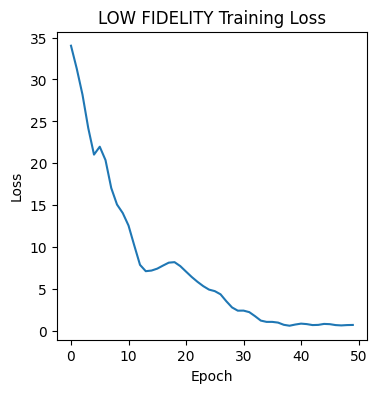

Final loss value:  0.7194544672966003


In [ ]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(LF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOW FIDELITY Training Loss')
plt.show()

print("Final loss value: ", LF_loss.item())

In [ ]:
# HF NN Hyper Paramters
input_dim = 1

# High Fidelity Neural Network
class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, input_dim, HF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, HF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(HF_hidden_dims[0], HF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(HF_hidden_dims[1], HF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(HF_hidden_dims[2], HF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(HF_hidden_dims[3], HF_hidden_dims[4])
    self.fc6 = torch.nn.Linear(HF_hidden_dims[4], HF_hidden_dims[5])
    self.fc7 = torch.nn.Linear(HF_hidden_dims[5], HF_hidden_dims[6])
    self.fc8 = torch.nn.Linear(HF_hidden_dims[6], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    # x = self.dropout(x)
    x = self.fc8(x)
    return x

HF_model = HighFidelityNetwork(input_dim, HF_hidden_dims, output_dim).to(device)

for param in HF_model.parameters():
  param.requires_grad = True

High Fidelity Model Training

In [ ]:
# High Fidelity Model Training

# Define the optimizer
HF_optimizer = torch.optim.Adam(HF_model.parameters())

# Training Step
HF_losses = []
for epoch in range(HF_num_epochs):
  HF_y_pred = HF_model(x_HF_train.to(device))
  HF_loss = criterion(HF_y_pred, y_HF_train.to(device))
  HF_losses.append(HF_loss.item())
  HF_optimizer.zero_grad()
  HF_loss.backward()
  HF_optimizer.step()

  
for param in HF_model.parameters():
  param.requires_grad = True

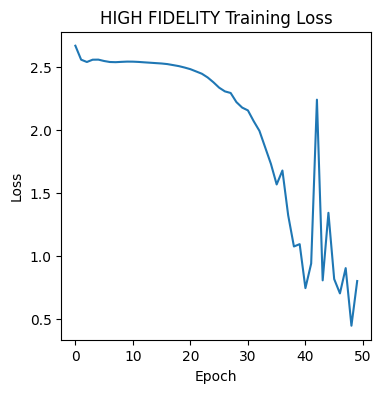

Final loss value:  0.8041853308677673


In [ ]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(HF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('HIGH FIDELITY Training Loss')
plt.show()

print("Final loss value: ", HF_loss.item())

In [ ]:
# Step 1: Predict HF points with LF Model
# Step 2: Add X_HF Points and output of the predictions from Step 1
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# Step 4: Add X...? and output of the LF model (similar to Step 2)
# Step 5: Predict this new arrray with the MFNN model from Step 3

In [ ]:
# Step 1: Predict HF points with LF Model & Step 2: Add X_HF Points and output of the predictions from Step 1
L1mean = LF_model(x_HF_train.to(device))

print(L1mean.shape)

L2train = np.hstack((x_HF_train, L1mean.cpu().detach().numpy())) # think of the house price example (sqr feet, rooms, garden, etc.)
L2train = torch.from_numpy(L2train) 
print(L2train.shape)

torch.Size([8, 1])
torch.Size([8, 2])


In [ ]:
# Step 3: Create a Third NN Model fitting the new X_HF Array from Step 2 and Y_HF_TRAIN values
# MFNN Hyper Paramters
input_dim = 2

# High Fidelity Neural Network
class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, input_dim, MF_hidden_dims, output_dim):
    super().__init__()
    self.fc1 = torch.nn.Linear(input_dim, MF_hidden_dims[0])
    self.fc2 = torch.nn.Linear(MF_hidden_dims[0], MF_hidden_dims[1])
    self.fc3 = torch.nn.Linear(MF_hidden_dims[1], MF_hidden_dims[2])
    self.fc4 = torch.nn.Linear(MF_hidden_dims[2], MF_hidden_dims[3])
    self.fc5 = torch.nn.Linear(MF_hidden_dims[3], output_dim)
    # self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    # x = self.dropout(x)
    x = self.fc5(x)
    return x

MF_model = MultiFidelityNetwork(input_dim, MF_hidden_dims, output_dim).to(device)

for param in MF_model.parameters():
  param.requires_grad = True

In [ ]:
# Multi Fidelity Model Training

# Define the optimizer
MF_optimizer = torch.optim.Adam(MF_model.parameters())

# Training Step
MF_losses = []
for epoch in range(MF_num_epochs):
  MF_y_pred = MF_model(L2train.to(device))
  MF_loss = criterion(MF_y_pred, y_HF_train.to(device))
  MF_losses.append(MF_loss.item())
  MF_optimizer.zero_grad()
  MF_loss.backward()
  MF_optimizer.step()
  
for param in MF_model.parameters():
  param.requires_grad = True

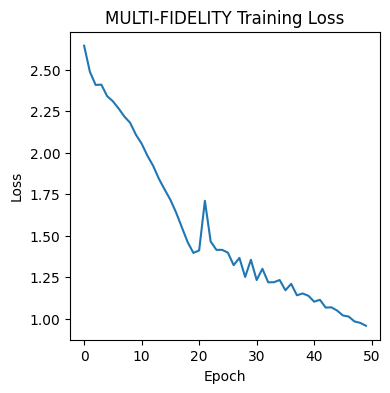

Final loss value:  0.9581072330474854


In [ ]:
# Plotting the Loss Change for LF Model
plt.figure(figsize = (4, 4))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MULTI-FIDELITY Training Loss')
plt.show()

print("Final loss value: ", MF_loss.item())

In [ ]:
# Running the Models with LF and HF points
y_pred_lf = LF_model(X.to(device))
y_pred_hf = HF_model(X.to(device))

# Step 4: Add X...? and output of the LF model (similar to Step 2)
L2test = np.hstack((X, y_pred_lf.cpu().detach().numpy()))
L2test = torch.from_numpy(L2test)
print(L2test.shape)

# Step 5: Predict this new arrray with the MFNN model from Step 3
y_pred_mf = MF_model(L2test.to(device))

torch.Size([1000, 2])


LF loss:  0.7194544672966003
HF loss:  0.8041853308677673
MF loss:  0.9581072330474854


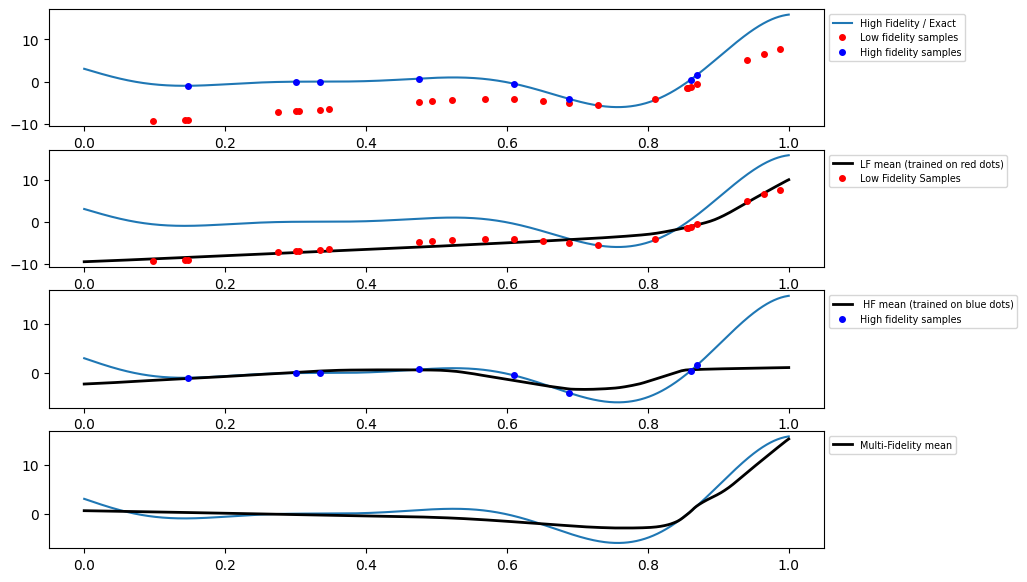

In [ ]:
# Plotting the predictions against the true values after converting from CUDA to CPU's memory
fig, axs = plt.subplots(4, figsize = (10, 7))

axs[0].plot(X,QH_a(X), label= "High Fidelity / Exact") # main result line we want to match with
axs[0].plot(x_LF_train, QL_a(x_LF_train), 'ro', markersize = 4, label = "Low fidelity samples")
axs[0].plot(x_HF_train, QH_a(x_HF_train), 'bo', markersize = 4, label = "High fidelity samples")
axs[0].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[1].plot(X, QH_a(X)) 
axs[1].plot(X, y_pred_lf.cpu().detach().numpy(),'k', lw=2, label= "LF mean (trained on red dots)")
axs[1].plot(x_LF_train, QL_a(x_LF_train), 'ro', markersize = 4, label = 'Low Fidelity Samples')
axs[1].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[2].plot(X, QH_a(X))
axs[2].plot(X, y_pred_hf.cpu().detach().numpy(), 'k', lw=2, label=" HF mean (trained on blue dots)")
axs[2].plot(x_HF_train, QH_a(x_HF_train),'bo', markersize = 4, label="High fidelity samples")
axs[2].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

axs[3].plot(X, QH_a(X))
axs[3].plot(X, y_pred_mf.cpu().detach().numpy(), 'k', lw=2, label="Multi-Fidelity mean")
axs[3].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='x-small')

print("LF loss: ", LF_loss.item())
print("HF loss: ", HF_loss.item())
print("MF loss: ", MF_loss.item())